### Classification d’images

#### 1. Décompressez les données dans un dossier, qui sera le chemin source. 
Dataset : https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip

#### 2. Définissez une fonction pour lire, redimensionner et stocker les données dans un dictionnaire, contenant les images, les étiquettes (animal), les noms de fichiers originaux et une description. 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import joblib
from skimage.io import imread
from skimage.transform import resize

 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
 
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [3]:
# modify to fit your system
data_path = fr'{os.getenv("HOME")}/anaconda3/projetIA/Reconnaissance_objet_HOG/Image'
#os.listdir(data_path)

#### 3. Créer le jeu de données en vous servant de votre fonction précédemment créée. 
Il y a pas mal d'animaux inclus dans le jeu de données, sélectionnez 8 classes d’animaux de votre choix. Nous définissons la largeur (et la hauteur) à 80 pixels.

In [3]:
base_name = 'animal_faces'
width = 120
height = 120
 
include = {'DogHead', 'CatHead', 'RabbitHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

MonkeyHead
EagleHead
CatHead
RabbitHead
PandaHead
DogHead
DeerHead


#### 4. Analysez le nouveau jeu de données fraîchement créé 
(nombre d’échantillons, les éléments “clés” des données, taille des images, labels des images).


In [4]:
from collections import Counter

base_name = 'animal_faces'
width = 120
height = 120
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1063
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120)animal images in rgb
image shape:  (120, 120, 3)
labels: ['Cat' 'Deer' 'Dog' 'Eagle' 'Monkey' 'Panda' 'Rabbit']


Counter({'Cat': 159,
         'Deer': 101,
         'Dog': 389,
         'Eagle': 97,
         'Monkey': 100,
         'Panda': 117,
         'Rabbit': 100})

#### 5. Affichez un exemple de chaque animal inclus dans le jeu de données :
Utilisez “np.unique” pour obtenir toutes les valeurs uniques dans la liste des étiquettes.
Configurer la figure et les axes matplotlib, en fonction du nombre d'étiquettes.
Faire un tracé pour chaque type d'étiquette. La méthode index renvoie l'index du premier élément correspondant à sa chaîne de recherche, label dans notre cas

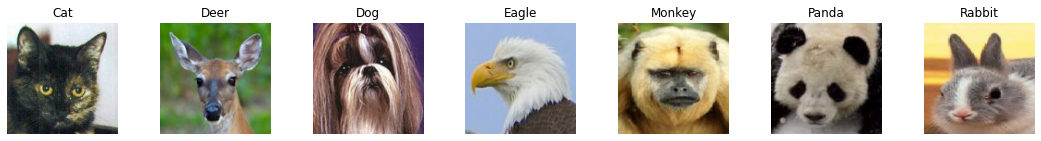

In [5]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [6]:
X = data['data']
y = np.array(data['label'])

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

#### 6. Diviser vos données en un ensemble de test et un ensemble de train
avec la fonction train_test_split de scikit-learn (80% de l'ensemble total pour l'entraînement et le reste pour l'ensemble de test). 
Dans l'ensemble de données, les photos sont classées par animal, nous ne pouvons donc pas simplement diviser à 80%, (si les données sont ordonnées et que nous nous divisons à une certaine position, nous nous retrouverons avec certains animaux (types) apparaissant dans un seul des deux ensembles).
Nous pouvons résoudre ce problème en mélangeant les données avant de les fractionner. De cette façon, nous égalisons les distributions dans l'ensemble de train et de test et les rendons comparables. La fonction “train_test_split” de sklearn fournit un paramètre shuffle pour prendre en charge cela tout en effectuant le fractionnement. “Random_state” amorce le mélange pour qu'il soit aléatoire, mais de manière reproductible.


In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y
)

#### 7. Vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire
 (examiner le nombre relatif de photos par catégorie).
 Que pensez-vous des distributions ? Existe-t-il un moyen de s’assurer de l’obtention de distributions égales dans l'ensemble d'apprentissage et de test ?

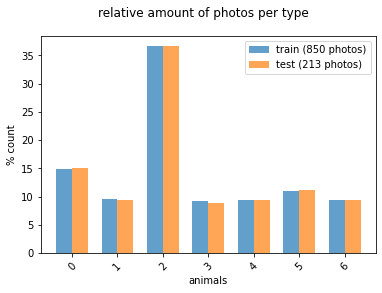

In [9]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('animals')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

#### 8. Traitement des données

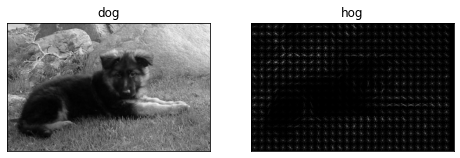

In [11]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('800px-Fritzi_GSD_puppy.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/2, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [12]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  100800
number of hog features:  16524


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

#### 9. Entraîner un classifieur. Nous commencerons par Stochastic Gradient Descent (SGD)
car il est rapide et fonctionne relativement bien.


In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
from skimage.feature import hog
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(3,3), 
    orientations=8, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

/home/roger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


(850, 12168)


In [23]:
import pickle

f = open('scalify_fit.pkl', 'wb')
pickle.dump(scalify_fit, f,-1)          # dump data to f
f.close()

In [24]:
with open('scalify_fit.pkl','rb') as file:
    scalify_fit = pickle.load(file)

In [ ]:
scalify_fit = scalify.fit(X_train_hog)

In [25]:
from sklearn import svm
#sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
svm_clf = svm.SVC(kernel='linear')
#sgd_clf.fit(X_train_prepared, y_train)
svm_clf.fit(X_train_prepared, y_train)

SVC(kernel='linear')

In [26]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify_fit.transform(X_test_hog)

In [27]:
y_pred = svm_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True]

Percentage correct:  86.85446009389672


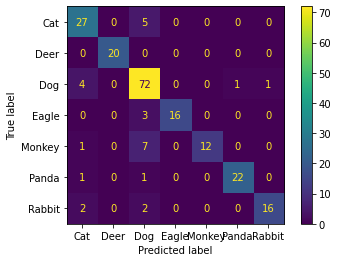

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(svm_clf, X_test_prepared, y_test)  

##### Test de prediction

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [31]:
file1 = "nounou1.jpg"
file2 = "bearfrontal0001.jpg"
file3 = "monkeyfrontal0001.jpg"

file4 = "01_08_18---Duck_web.jpg"

file5 = "mousefrontal0001.jpg"
img = imread(file1)
width = 120
height = 120
img = resize(img, (width, height))

In [32]:
#svc = SVC(random_state=42, max_iter=1000, tol=1e-3)
svm_clf.fit(X_train_prepared, y_train)
X_test_gray = grayify.transform([img])
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
y_pred = svm_clf.predict(X_test_prepared)
print(np.array(y_pred))

['Eagle']


In [33]:
len(X_test_prepared[0])

12168

In [34]:
import pickle

f = open('svm_clf_image_classifier.pkl', 'wb')
pickle.dump(svm_clf, f,-1)          # dump data to f
f.close()

In [35]:
with open('svm_clf_image_classifier.pkl','rb') as file:
    image_clf = pickle.load(file)

In [36]:
from sklearn.neural_network import MLPClassifier
Mlp_clf = MLPClassifier()
Mlp_clf.fit(X_train_prepared, y_train)

MLPClassifier()

In [37]:
f = open('Mlp_clf_image_classifier.pkl', 'wb')
pickle.dump(Mlp_clf, f,-1)          # dump data to f
f.close()

In [38]:
with open('Mlp_clf_image_classifier.pkl','rb') as file:
    Mlp_image_clf = pickle.load(file)

In [40]:
img = imread("test/animaux/6.jpg")
width = 120
height = 120
img = resize(img, (width, height))
X_test_gray = grayify.transform([img])
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
y_pred = Mlp_image_clf.predict(X_test_prepared)
y_pred

array(['Panda'], dtype='<U6')

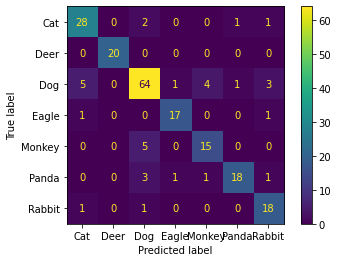

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y
)
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify_fit.transform(X_test_hog)
y_pred = Mlp_image_clf.predict(X_test_prepared)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(Mlp_image_clf, X_test_prepared, y_test)  

In [44]:
import pandas as pd

labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


#### 10. Évaluer les faux positifs grâce à une matrice de confusion.

In [45]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


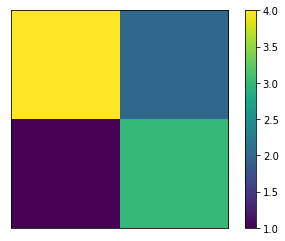

In [46]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();


 ['Cat', 'Deer', 'Dog', 'Eagle', 'Monkey', 'Panda', 'Rabbit']


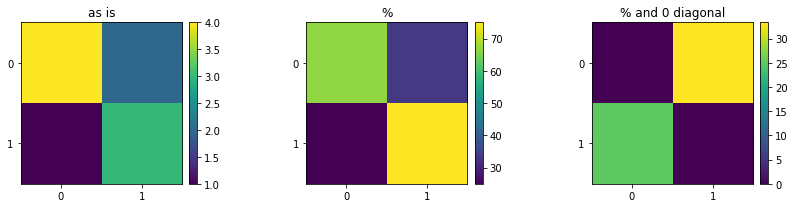

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_conf_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_conf_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

#### 11. Mettre en place un pipeline 
qui pré-traite les données (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), entraîne le modèle et nous permet de modifier les paramètres plus facilement.
En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les paramètres, nous pouvons utiliser un GridSearchCV. 

In [48]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

/home/roger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


Percentage correct:  84.97652582159624


#### 12. Pour cela, définir une grille de paramètres (param_grid = [{...}]).

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear'),
             GaussianNB(),
             MLPClassifier()
         ]
    }
]

#### 13. Évaluer dans le même objet Grid Search, le classifieur SGD, le classifieur SVM, ainsi qu’un classifieur Naïve Bayes.

Une fois le Grid Search terminé, le modèle sera entraîné une dernière fois, en utilisant l'ensemble complet d'apprentissage et les paramètres optimaux. 

Que pouvez-vous conclure de ces modèles, en étudiant le fonctionnement intrinsèque du SVM et du Naive Bayes, est-on capable d’anticiper quel algorithme sera le plus efficace pour cette tâche de classification d’images ? 

###### Naive Bayes methods
are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [51]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/roger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


#### 14. Évaluer les résultats des modèles 
(avec paramètres optimaux calculés par le Grid Search), quel classifieur offre de meilleurs scores pour cette tâche ?

#### 15. Enregistrer vos résultats dans un fichier pickle (joblib) afin de pouvoir recharger les résultats lorsque vous en aurez besoin (par ex avec Heroku). 

In [52]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [53]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

In [54]:
# the highscore during the search
grid_res.best_score_

0.8600258796595829

In [55]:
pp.pprint(grid_res.best_params_)

{   'classify': SVC(kernel='linear'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


In [56]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', round (100*np.sum(best_pred == y_test)/len(y_test)))

Percentage correct:  87


In [57]:
cmx_svm = confusion_matrix(y_test, best_pred)

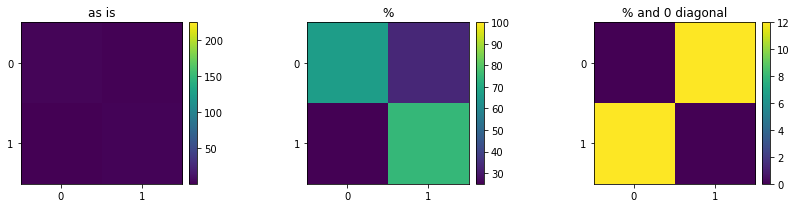

In [58]:
plot_conf_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

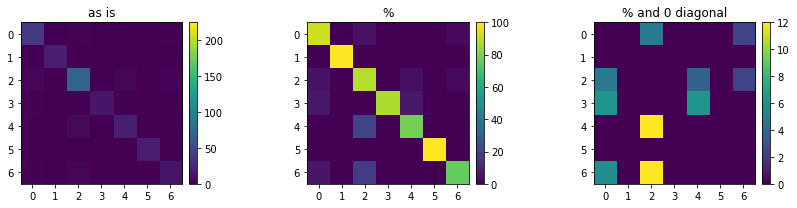

In [64]:
plot_conf_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

#### 16. Créer votre propre dataset avec des images provenant de Google Image. 
Appliquer votre pipeline sur ce nouveau jeu de données. Au besoin, relancer un Grid Search.

In [1]:
import os
def resize_all_new(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary,
    together with labels and metadata. The dictionary is written to a pickle file
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
 
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})landscapes in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [2]:
# modify to fit your system
data_path_new = fr'{os.getenv("HOME")}/anaconda3/projetIA/Reconnaissance_objet_HOG/Intel_Image_Classification/seg_train/seg_train'
os.listdir(data_path_new)

['sea', 'mountain', 'forest', 'glacier', 'buildings', 'street']

In [4]:
import joblib
from skimage.io import imread
from skimage.transform import resize

base_name = 'landscapes'
width = 120
height  = 120
include = {'buildings', 'forest', 'glacier', 
           'mountain', 'sea', 'street'}
 
resize_all_new(src=data_path_new, pklname=base_name, width=width, include=include)

sea
mountain
forest
glacier
buildings
street


In [3]:
import joblib
import numpy as np
from collections import Counter
base_name = 'landscapes'
width = 120
height  = 120
include = {'buildings', 'forest', 'glacier', 
           'mountain', 'sea', 'street'}
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  14034
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120)landscapes in rgb
image shape:  (120, 120, 3)
labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Counter({'sea': 2274,
         'mountain': 2512,
         'forest': 2271,
         'glacier': 2404,
         'buildings': 2191,
         'street': 2382})

In [4]:
import matplotlib.pyplot as plt
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [5]:
X = data['data']
y = np.array(data['label'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [8]:
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.transform import rescale
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(3,3), 
    orientations=8, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(11227, 12168)


In [9]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_prepared, y_train)

MLPClassifier()

In [27]:
# call fit_transform on each transform converting X_train step by step
X_test_gray = grayify.fit_transform(X_test)
X_test_hog = hogify.fit_transform(X_test_gray)
X_test_prepared = scalify.fit_transform(X_test_hog)

In [28]:
y_pred = mlp_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct mlp_clf: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True False  True  True  True False False  True  True  True False
 False False  True  True  True  True False False  True  True  True  True
  True]

Percentage correct mlp_clf:  69.50480940505878


#### With other classifiers

In [83]:
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train_prepared, y_train)

SVC(kernel='linear')

In [84]:
y_pred = svm_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct svm_clf: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False  True False False  True  True False  True False  True False  True
 False False  True  True  True  True False False  True False  True  True
  True]

Percentage correct svm_clf:  62.45101531884574


In [85]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

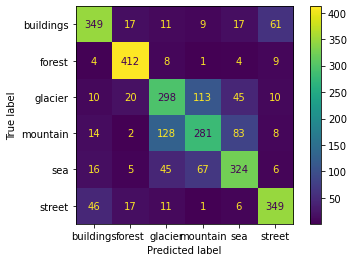

In [86]:
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mlp_clf, X_test_prepared, y_test)  

In [32]:
import pandas as pd
res_mlp_clf = 69.5
res_svm_clf = 62.45
res = pd.DataFrame([res_mlp_clf, res_svm_clf], index = ['MLPClassifier','SvmClassifier'] ,columns =['accuracy_score'])
res 

,accuracy_score
MLPClassifier,69.50
SvmClassifier,62.45


In [33]:
file1 = "test/3.jpg" #street => forest (presence d'arbres sur l photo)
file2 = "test/5.jpg" #building => building OK
file3 = "test/6.jpg" # mer => sea 0K
file4 = "test/11.jpg" #montain => glacier OK
file5 = "test/14.jpg" #street => street OK
file6 = "test/22.jpg" #forest => forest OK
file7 = "test/25.jpg" #mer => mer : OK
file8 = "test/28.jpg" #glacier => glacier OK
file9 = "test/30.jpg" #glacier => glacier OK

In [34]:
img = imread(file1)
width = 120
height = 120
img = resize(img, (width, height))

In [35]:
X_test_gray = grayify.transform([img])
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
y_pred = mlp_clf.predict(X_test_prepared)
print(np.array(y_pred))

['forest']


In [10]:
import pickle

f = open('places_mlp_clf.pkl', 'wb')
pickle.dump(mlp_clf, f,-1)          # dump data to f
f.close()

#### 17. Vous vous rendez compte rapidement que la tâche de classification en Machine Learning atteint rapidement des limites de performance. 
Ne serait-ce pas le moment idéal pour poursuivre ce travail avec les réseaux neuronaux et plus spécifiquement les réseaux convolutionnels

#### 18. Développer une interface utilisateur (Dash) permettant de charger une image, puis de retourner le label de l’image (la classe).

In [ ]:
Voir le fichier HOG_detection.py